In [14]:
# Step 1: Define constants

import numpy as np
from torch.nn import CrossEntropyLoss, NLLLoss

# Run specific
DATASET = "fashion-mnist" # "mnist", "fashion-mnist", "cifar"
EPOCHS = 10
QUBITS = 4
SIMPLE_NEURONS_PER_FEATURE_PER_ROW = 8
LOSS_FUNC = CrossEntropyLoss()
PERTURB = False
RESUME_TRAINING = True
CHOOSE_NEW_RECEPTIVE_FIELDS = False
CHOOSE_NEW_TRAINING_DATA = False
RUN = "2"
# Constants
QC_REPETITIONS = 1
CLASSES = 4
BATCH_SIZE = 256
FEATURE_BRIGHTNESS = 2
FEATURE_ANGLES = 2
FEATURE_FREQUENCIES = 1

#For dynamic kernels
KERNEL="dynamic"
MIN_KERNEL_SIZE = 5
MIN_KERNEL_SIZE_GABOR = 2

#Derived:
TOTAL_FEATURES_PER_SITE = FEATURE_BRIGHTNESS + FEATURE_ANGLES * FEATURE_FREQUENCIES * 2 # 2 values per gabor
TOTAL_FEATURES = SIMPLE_NEURONS_PER_FEATURE_PER_ROW * SIMPLE_NEURONS_PER_FEATURE_PER_ROW * TOTAL_FEATURES_PER_SITE

FILENAME_PREFIX = f'v3-{DATASET}-r{RUN}-q{QUBITS}-{QC_REPETITIONS}-c{CLASSES}-n{TOTAL_FEATURES}-k{KERNEL}'
COMMON_FILENAME_PREFIX = f'v3-{DATASET}-r{RUN}-n{TOTAL_FEATURES}-k{KERNEL}'

if DATASET == "cifar":
  IMAGE_WIDTH = 32
  TARGETS = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])  
elif DATASET == "fashion-mnist":
  IMAGE_WIDTH = 28
  TARGETS = np.array(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]) 
else: 
  IMAGE_WIDTH = 28
  TARGETS = np.array([0,1,2,3,4,5,6,7,8,9])


## Settings
DEBUG = False
SAMPLE_RUN = False
SAMPLE_ITERATIONS = 10


In [15]:
# Step 2: Necessary imports

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Arrow
from itertools import cycle
import random
import os.path as path
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from datetime import datetime

# Additional torch-related imports
import torch
from torch import Tensor, cat, no_grad, manual_seed
from torch.nn import Linear, MSELoss, Softmax
from torch.optim import LBFGS
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Bilinear,
    Dropout2d,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

# Project specific imports
from canonicallayers.brightnessextractor import extractBrightness, extractBrightnessAt
from canonicallayers.gaborfilterextractor import extract_power_feats
from canonicallayers.perturbations import skew, rotate, noise, elastic_transform
algorithm_globals.random_seed = 42

In [16]:
# Step 3: Prepare Training data
# -------------

train_loader = torch.load(f'checkpoints/{COMMON_FILENAME_PREFIX}-training.pt')
test_loader = torch.load(f'checkpoints/{COMMON_FILENAME_PREFIX}-testing.pt')



images shape torch.Size([256, 1, 28, 28])


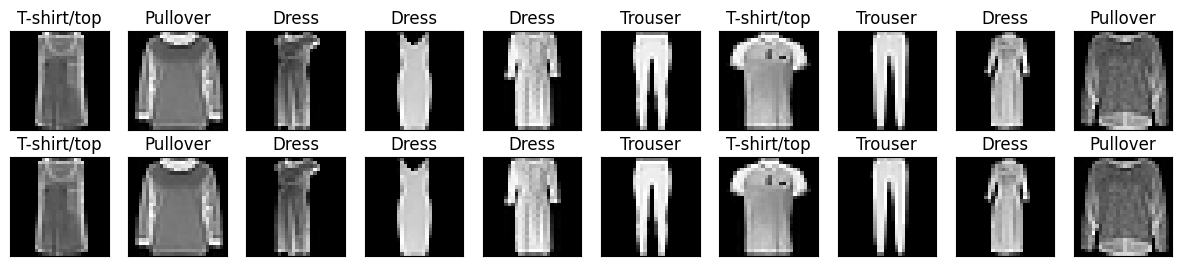

In [17]:
# Step 4 - Visualize dataset

n_samples_show = 10

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, sharex=True, figsize=(15, 3))
images, targets = data_iter.__next__()
print("images shape", images.shape)

while n_samples_show > 0:
    originalImage = images[n_samples_show,0]
      
    if(PERTURB):
      perturbation = "none"
      match random.randint(0, 3):
          case 0:
            perturbedImage = skew(originalImage.numpy())
            perturbation = "skew"
          case 1:
            angle = 3*np.random.random()/5
            perturbedImage = rotate(originalImage.numpy(), angle)
            perturbation = f"rotate {np.round(angle*180/np.pi)}°"
          case 2:
            perturbedImage = noise(originalImage.numpy())
            perturbation = "noise"
          case _:
            perturbedImage = elastic_transform(originalImage.numpy())
            perturbation = "elastic"
      perturbedData = torch.tensor(perturbedImage).unsqueeze(0).unsqueeze(0)

    axes[0,n_samples_show - 1].imshow(originalImage.numpy().squeeze(), cmap="gray")
    axes[0,n_samples_show - 1].set_xticks([])
    axes[0,n_samples_show - 1].set_yticks([])
    axes[0,n_samples_show - 1].set_title(TARGETS[targets[n_samples_show].item()])
    if(PERTURB):
      axes[1,n_samples_show - 1].imshow(perturbedData[0].numpy().squeeze(), cmap="gray")
      axes[1,n_samples_show - 1].set_xticks([])
      axes[1,n_samples_show - 1].set_yticks([])
      axes[1,n_samples_show - 1].set_title("{}".format(perturbation))
    else:
      axes[1,n_samples_show - 1].imshow(originalImage.numpy().squeeze(), cmap="gray")
      axes[1,n_samples_show - 1].set_xticks([])
      axes[1,n_samples_show - 1].set_yticks([])
      axes[1,n_samples_show - 1].set_title(TARGETS[targets[n_samples_show].item()])
      
    n_samples_show -= 1

In [18]:
# Step 6 - Setup Feature Extraction parameters

gaborReceptiveFields = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborReceptiveFields.pt")
gaborKernels = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborKernels.pt")
gaborAngleTunings = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborAngleTunings.pt")
gaborFrequencyTunings = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborFrequencyTunings.pt")


In [19]:
# Step 12 - Load previous results

loss_list = []  # Store loss history
training_stats = [0, 0.0, 0] #Epochs, Accuracy, Training Time
if(path.isfile(f'checkpoints/{FILENAME_PREFIX}-losslist.pt')):
  loss_list = torch.load(f"checkpoints/{FILENAME_PREFIX}-losslist.pt")
  print("loss list loaded")
if(path.isfile(f'checkpoints/{FILENAME_PREFIX}-trainingstats.pt')):
  training_stats = torch.load(f"checkpoints/{FILENAME_PREFIX}-trainingstats.pt")
  print("training stats loaded")
  

loss list loaded


Completed Epochs 0 Accuracy 0.0


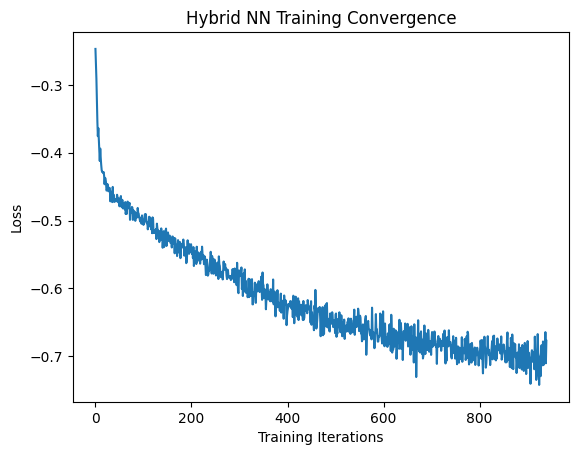

In [24]:



# Step 13 - Plot Prior Losses
print("Completed Epochs", training_stats[0], "Accuracy", training_stats[1])
plt.plot(loss_list[0:940])
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Loss")
plt.show()

Load the model weights, and test the model.
For now, test using QNN simulator.

In [21]:
# Step 17 - Plot feature extraction kernels

def plotKernel(ax, locations, kernels, tunings, title, feature):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title)
  imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1
  ax.plot([0, 0],[IMAGE_WIDTH, IMAGE_WIDTH])
  cycol = cycle('bgrcmk')
  Y = []
  X = []
  C=[]
  S=[]
  kernelSize=[]
  tuningX=[]
  tuningY=[]
  tuningValue=np.array([])
  anyOneTuningValue = []
  # print("locations", locations.shape, "tunings", tunings)
  for iy, ix in np.ndindex(locations.shape):
    # if(tunings.shape[0] < iy+1):
    #   print("breaking", "tunings.shape", tunings.shape, "iy+1", iy+1)
    #   break
    y = locations[iy, ix] // imgWidth
    x = locations[iy, ix] % imgWidth
    Y.append(y.item())
    X.append(x.item())
    ks = kernels[iy, ix].item()
    # print("ks", ks)
    kernelSize.append(ks * ks * 2000/(IMAGE_WIDTH*IMAGE_WIDTH))
    tuningX.append(x + ks/2)
    tuningY.append(y + ks/2)
    size = kernels[iy, ix].item()
    S.append(size)
    # print("iy", iy, "ix", ix, "tunings[iy, ix]", tunings[iy, ix].shape, "tuningValue", len(tuningValue))
    tuningValue = np.concatenate((tuningValue, tunings[:, iy, ix].numpy()))
    anyOneTuningValue.append(np.random.choice(tunings[:, iy, ix].numpy().astype(int)))
    angles = tunings[:, iy, ix].numpy()
    topX = x.item()
    topY = IMAGE_WIDTH-y.item()-size
    radius = 1
    centerX = topX + int(size/2)
    centerY = topY + int(size/2)
    color = next(cycol)
    if(feature == "rect"):
      ax.add_patch(Rectangle((topX, topY), size, size, facecolor= 'none', edgecolor=color, alpha=0.5))
    
    # ax.add_patch(Circle((centerX, centerY), radius=radius, alpha=0.1))
    for a in angles:
      dx = int((size/2) * np.cos(a))
      dy = - int((size/2) * np.sin(a))
      # print("center", centerX, centerY, "angle", a * 180/np.pi, "size", size, "dx", dx, "dy", dy)
      if(feature == "arrows"):
        ax.add_patch(Arrow(centerX, centerY, dx, dy, alpha=0.2, facecolor=color))


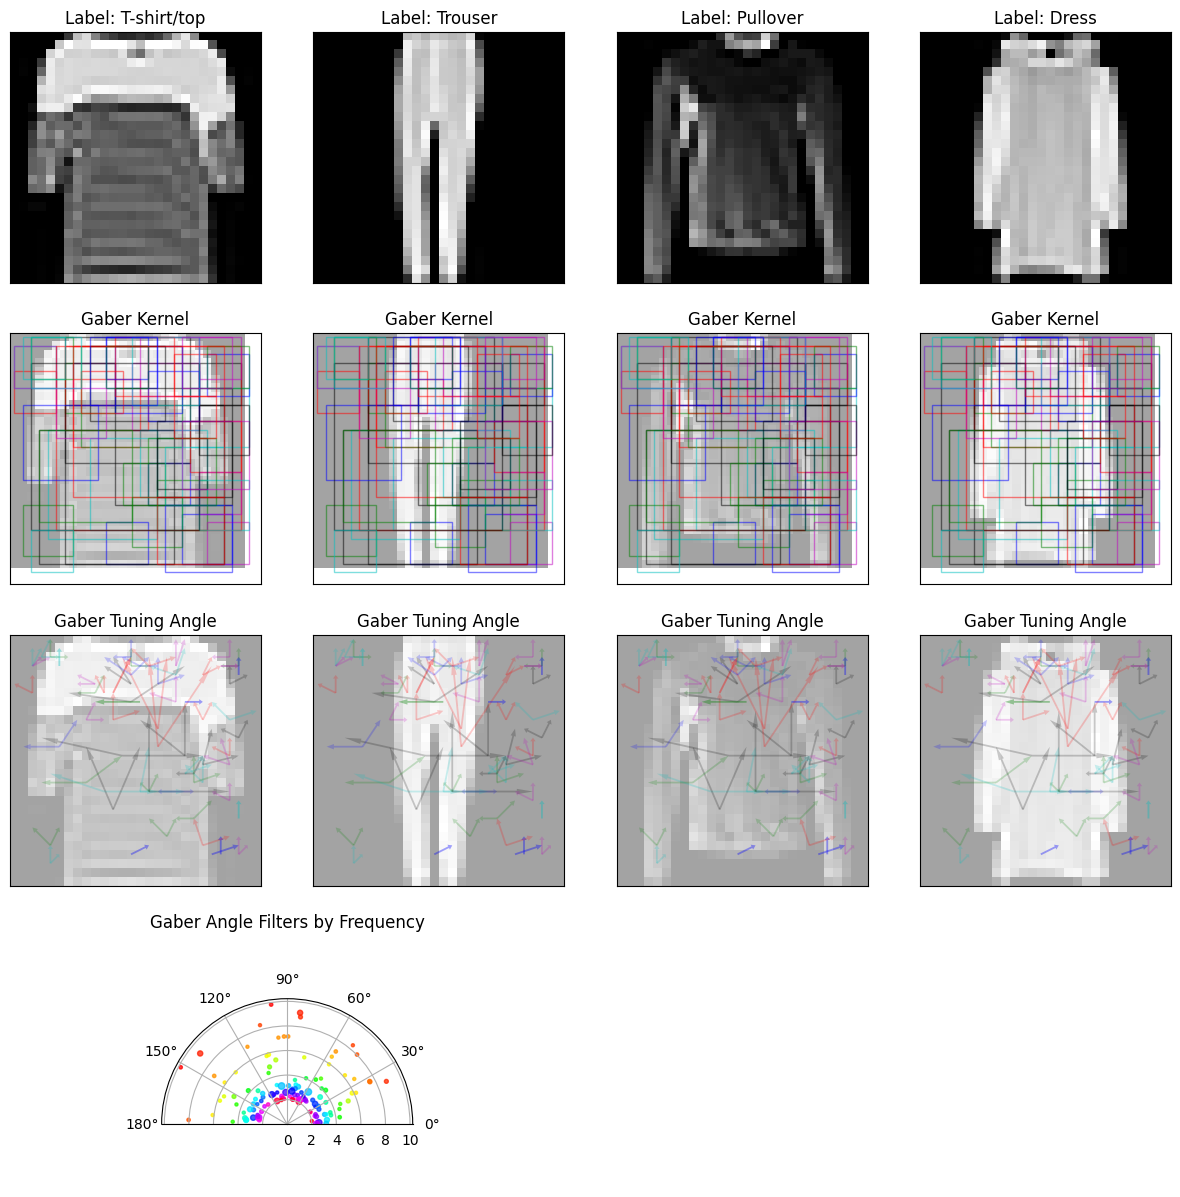

In [22]:
# Step 18 - Predict
def plot(axes, count, data, idx, perturbations, target, feature):
  perturbedData = data[idx,0, :, :].unsqueeze(1)
  axes[0,count].imshow(perturbedData[0].numpy().squeeze(), cmap="gray")
  axes[0,count].set_xticks([])
  axes[0,count].set_yticks([])
  if(PERTURB):
    axes[0,count].set_title("{}, Label: {}".format(perturbations[idx], TARGETS[target[idx].item()]))
  else:
    axes[0,count].set_title("Label: {}".format(TARGETS[target[idx].item()]))
  axes[1,count].imshow(perturbedData[0].numpy().squeeze(), cmap="gray", alpha=0.2)
  axes[2,count].imshow(perturbedData[0].numpy().squeeze(), cmap="gray", alpha=0.2)
  if(feature == "rect"):
    plotKernel(axes[1,count], gaborReceptiveFields, gaborKernels, gaborAngleTunings, "Gaber Kernel", feature)
  else:
    plotKernel(axes[2,count], gaborReceptiveFields, gaborKernels, gaborAngleTunings, "Gaber Tuning Angle", feature)



fig, axes = plt.subplots(nrows=4, ncols=CLASSES, figsize=(15, 15))

dataWidth = SIMPLE_NEURONS_PER_FEATURE_PER_ROW
imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1

for batch_idx, (data, target) in enumerate(train_loader):
  perturbations = []
  class1Indices = (target == 0).nonzero()
  class2Indices = (target == 1).nonzero()
  class3Indices = (target == 2).nonzero()
  class4Indices = (target == 3).nonzero()
  plot(axes, 0, data, class1Indices[0], perturbations, target, "arrows")
  plot(axes, 1, data, class2Indices[0], perturbations, target, "arrows")
  plot(axes, 2, data, class3Indices[0], perturbations, target, "arrows")
  plot(axes, 3, data, class4Indices[0], perturbations, target, "arrows")
  plot(axes, 0, data, class1Indices[0], perturbations, target, "rect")
  plot(axes, 1, data, class2Indices[0], perturbations, target, "rect")
  plot(axes, 2, data, class3Indices[0], perturbations, target, "rect")
  plot(axes, 3, data, class4Indices[0], perturbations, target, "rect")

  axes[3,0].remove()
  axes[3,1].remove()
  axes[3,2].remove()
  axes[3,3].remove()

  ax = fig.add_subplot(4, 4, (13, 14), projection='polar')
  ax.set_title("Gaber Angle Filters by Frequency")
  ax.set_thetamin(0)
  ax.set_thetamax(180)
  cTunings = gaborAngleTunings.unsqueeze(0).repeat(FEATURE_FREQUENCIES, 1,1,1)
  cFrequencies = gaborFrequencyTunings.unsqueeze(1).repeat(1, FEATURE_ANGLES, 1,1)
  cKernels = gaborKernels.unsqueeze(0).unsqueeze(1).repeat(FEATURE_FREQUENCIES, FEATURE_ANGLES, 1,1)

  ax.scatter(cTunings, 1/cFrequencies, c=cFrequencies, s=cKernels, cmap='hsv', alpha=0.75)
  break


In [23]:
import qiskit.tools.jupyter

%qiskit_version_table